# Import Libraries

In [1]:
from datetime import datetime, date
from keras.preprocessing.sequence import TimeseriesGenerator
# from keras.models import Sequential, load_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import zipfile
import warnings
warnings.filterwarnings("ignore")

# Extract Data
Extract and save data locally in /tmp folder

In [2]:
local_zip = '/content/drive/MyDrive/Colab Notebooks/Data/city_temperature.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

# Read Data

In [3]:
data = pd.read_csv("/tmp/city_temperature.csv")
data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


# Preprocess Data

In [4]:
data = data.loc[(data.City == 'Jakarta')]
data['Date'] = pd.to_datetime((data.Year*10000 + data.Month*100 + data.Day).apply(str), format='%Y%m%d')
data.AvgTemperature.replace(-99, np.NaN, inplace=True)
data.AvgTemperature.ffill(inplace=True)
data = data.loc[(data.Date >= '1995-01-01') & (data.Date < '2020-01-01'), ['Date', 'AvgTemperature']]
data.set_index('Date', inplace= True)
data.head()

,AvgTemperature
Date,
1995-01-01,85.0
1995-01-02,82.3
1995-01-03,81.7
1995-01-04,83.1
1995-01-05,80.6


# Split Data

In [5]:
train, test = train_test_split(data.values, test_size=0.2, shuffle=False)

# Rescale Data

In [6]:
scaler = MinMaxScaler()
train_scale = scaler.fit_transform(train.reshape(-1, 1))
test_scale = scaler.fit_transform(test.reshape(-1, 1))

In [7]:
split=int((1-0.2)*len(data))

date_train = data.index[:split]
date_test = data.index[split:]

In [8]:
look_back = 20
train_gen = TimeseriesGenerator(train_scale, train_scale, length=look_back, batch_size=20)     
test_gen = TimeseriesGenerator(test_scale, test_scale, length=look_back, batch_size=1)

# Construct the Forecasting Model

In [9]:
model_forecast = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=(look_back, 1)),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(1)
])

model_forecast.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 32)            4352      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


# Run the Forecasting Model using SGD Optimizer

In [10]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model_forecast.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
model_forecast.fit_generator(train_gen, epochs=10, verbose=1)

Epoch 1/10
365/365 [==============================] - 21s 52ms/step - loss: 0.1227 - mae: 0.4735
Epoch 2/10
365/365 [==============================] - 19s 52ms/step - loss: 0.0284 - mae: 0.2050
Epoch 3/10
365/365 [==============================] - 19s 52ms/step - loss: 0.0137 - mae: 0.1309
Epoch 4/10
365/365 [==============================] - 19s 53ms/step - loss: 0.0111 - mae: 0.1178
Epoch 5/10
365/365 [==============================] - 19s 52ms/step - loss: 0.0107 - mae: 0.1164
Epoch 6/10
365/365 [==============================] - 19s 52ms/step - loss: 0.0108 - mae: 0.1158
Epoch 7/10
365/365 [==============================] - 19s 52ms/step - loss: 0.0103 - mae: 0.1133
Epoch 8/10
365/365 [==============================] - 19s 53ms/step - loss: 0.0106 - mae: 0.1150
Epoch 9/10
365/365 [==============================] - 19s 52ms/step - loss: 0.0107 - mae: 0.1159
Epoch 10/10
365/365 [==============================] - 19s 53ms/step - loss: 0.0102 - mae: 0.1129


# Predict Some Range of Data

In [11]:
pred = scaler.inverse_transform(model_forecast.predict_generator(test_gen))

# Compare MAE and 10% Scale of Data

In [12]:
mae = round(metrics.mean_absolute_error(data.values[split+look_back:],pred), 2)
scale10 = round((data.AvgTemperature.max() - data.AvgTemperature.min()) * (10 / 100), 2)

if mae < scale10:
  print("The MAE Score is " + str(mae) + " which is smaller than " + str(scale10) + ". It is a Good Model!")
else:
  print("The MAE Score is " + str(mae) + " which is greater than " + str(scale10) + ". Fix the model again!")

The MAE Score is 1.33 which is smaller than 1.93. It is a Good Model!


# Visualize Real Data

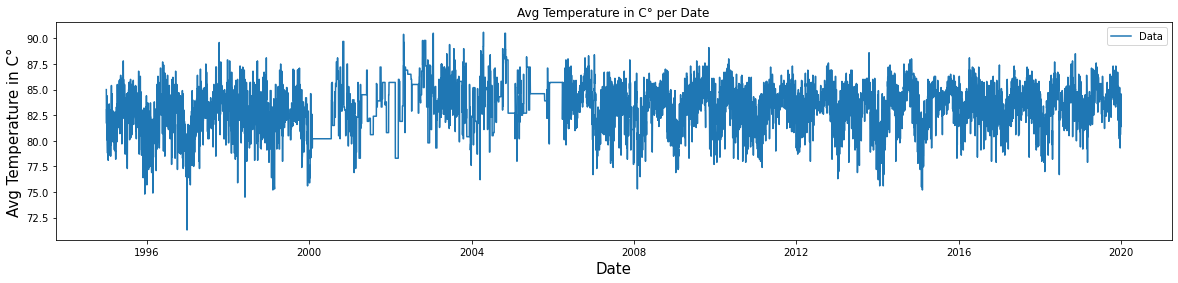

In [13]:
plt.figure(figsize=(20,4))
plt.plot(data.index, data.values, label = "Data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

# Visualize Forecasting Data

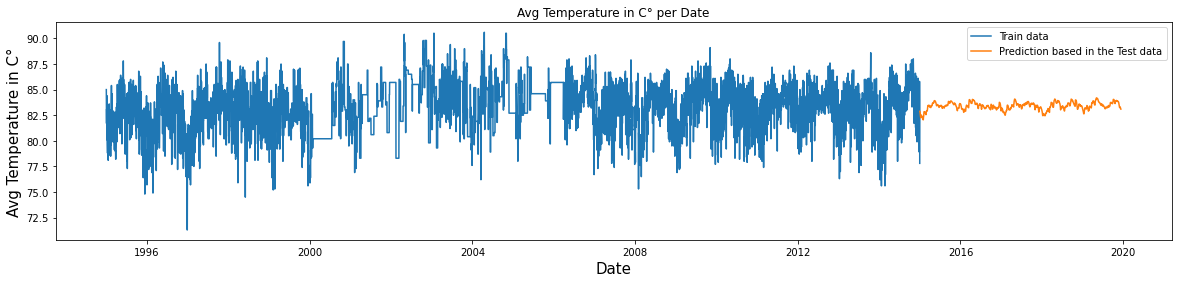

In [14]:
plt.figure(figsize=(20,4))
plt.plot(date_train, train, label = "Train data")
plt.plot(date_test[:-look_back], pred, label = "Prediction based in the Test data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

# Compare Real and Forecasting Data

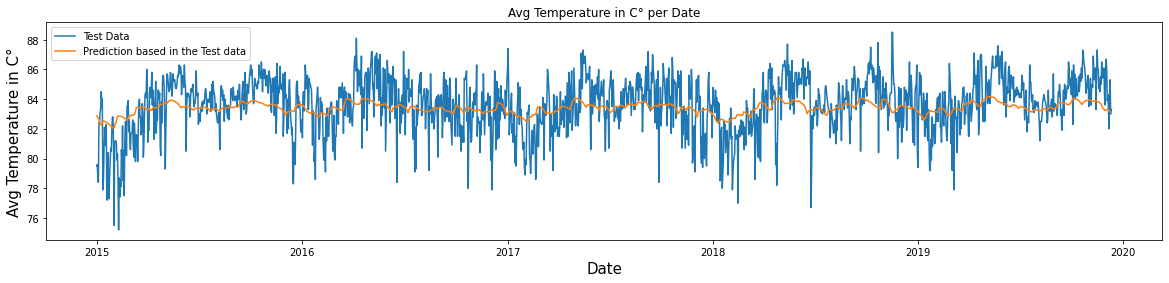

In [15]:
plt.figure(figsize=(20,4))
plt.plot(date_test[:-look_back], test.reshape(-1)[:-look_back], label = "Test Data")
plt.plot(date_test[:-look_back], pred, label = "Prediction based in the Test data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

# Run the Forecasting Model using ADAM Optimizer

In [16]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model_forecast.compile(loss='mae', optimizer='adam')
model_forecast.fit_generator(train_gen, epochs=10, verbose=1)

Epoch 1/10
365/365 [==============================] - 19s 50ms/step - loss: 0.1053
Epoch 2/10
365/365 [==============================] - 18s 49ms/step - loss: 0.0949
Epoch 3/10
365/365 [==============================] - 18s 49ms/step - loss: 0.0898
Epoch 4/10
365/365 [==============================] - 18s 49ms/step - loss: 0.0858
Epoch 5/10
365/365 [==============================] - 18s 49ms/step - loss: 0.0815
Epoch 6/10
365/365 [==============================] - 18s 49ms/step - loss: 0.0785
Epoch 7/10
365/365 [==============================] - 18s 49ms/step - loss: 0.0762
Epoch 8/10
365/365 [==============================] - 18s 49ms/step - loss: 0.0747
Epoch 9/10
365/365 [==============================] - 18s 50ms/step - loss: 0.0747
Epoch 10/10
365/365 [==============================] - 18s 49ms/step - loss: 0.0756


# Predict Some Range of Data

In [17]:
pred = scaler.inverse_transform(model_forecast.predict_generator(test_gen))

# Compare MAE and 10% Scale of Data

In [18]:
mae = round(metrics.mean_absolute_error(data.values[split+look_back:],pred), 2)
scale10 = round((data.AvgTemperature.max() - data.AvgTemperature.min()) * (10 / 100), 2)

if mae < scale10:
  print("The MAE Score is " + str(mae) + " which is smaller than " + str(scale10) + ". It is a Good Model!")
else:
  print("The MAE Score is " + str(mae) + " which is greater than " + str(scale10) + ". Fix the model again!")

The MAE Score is 1.1 which is smaller than 1.93. It is a Good Model!


# Visualize Real Data

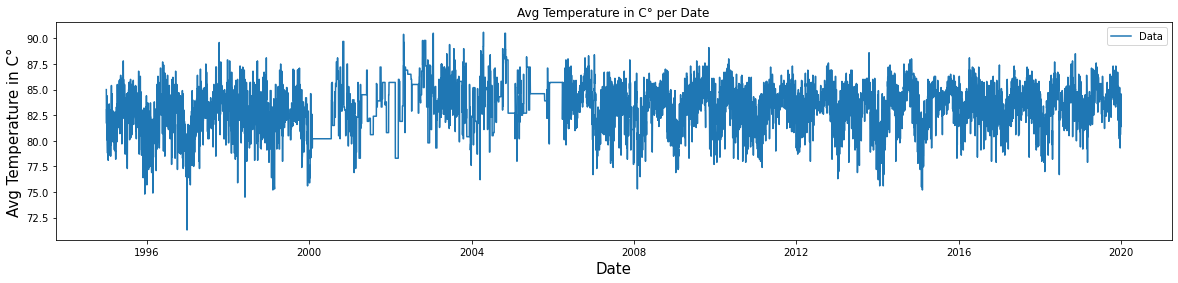

In [19]:
plt.figure(figsize=(20,4))
plt.plot(data.index, data.values, label = "Data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

# Visualize Forecasting Data

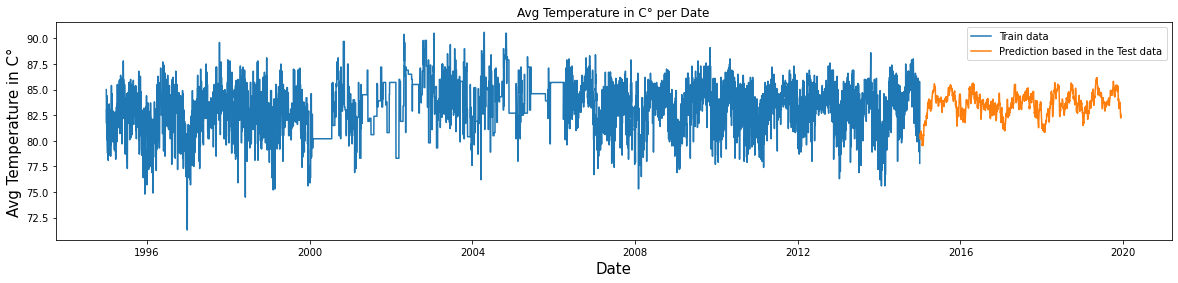

In [20]:
plt.figure(figsize=(20,4))
plt.plot(date_train, train, label = "Train data")
plt.plot(date_test[:-look_back], pred, label = "Prediction based in the Test data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

# Compare Real and Forecasting Data

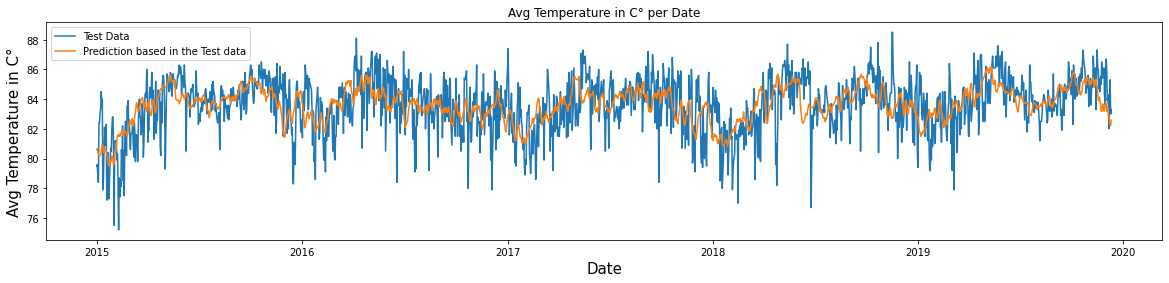

In [21]:
plt.figure(figsize=(20,4))
plt.plot(date_test[:-look_back], test.reshape(-1)[:-look_back], label = "Test Data")
plt.plot(date_test[:-look_back], pred, label = "Prediction based in the Test data")
plt.title('Avg Temperature in C° per {}'.format(data.index.name))
plt.xlabel('{}'.format(data.index.name),fontsize=15)
plt.ylabel('Avg Temperature in C°',fontsize=15)
plt.legend()
plt.show()

# How can you make the model more highly volatile?

I have tried various methods, but the prediction results are still not able to handle the high volatility. Thank you.